In [1]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d mohitsingh1804/plantvillage


Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
 93% 759M/818M [00:04<00:01, 54.5MB/s]
100% 818M/818M [00:04<00:00, 203MB/s] 


In [8]:
!unzip plantvillage.zip


Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

In [9]:
import os

os.listdir()


['.config', 'kaggle.json', 'plantvillage.zip', 'PlantVillage', 'sample_data']

In [10]:
len(os.listdir("PlantVillage"))
os.listdir("PlantVillage")



['train', 'val']

In [11]:
train_dir = "/content/PlantVillage/train"
val_dir   = "/content/PlantVillage/val"


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
img_size = (224, 224)
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Increased from 20 to handle shaky hands
    width_shift_range=0.2,   # Moves image left/right (if leaf isn't centered)
    height_shift_range=0.2,  # Moves image up/down
    shear_range=0.2,         # Distorts image (different camera angles)
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'      # Fills in pixels lost during rotation/shifting
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [15]:
print("Classes:", train_data.num_classes)
print(train_data.class_indices)


Classes: 38
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight':

In [16]:
import numpy as np

class_names = list(train_data.class_indices.keys())



Label vector: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class name: Apple___Cedar_apple_rust


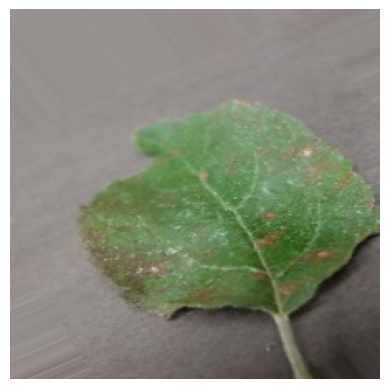

In [17]:
import matplotlib.pyplot as plt

images, labels = next(train_data)

plt.imshow(images[0])
plt.axis('off')
label_index = np.argmax(labels[0])

print("Label vector:", labels[0])
print("Class name:", class_names[label_index])



In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


In [19]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [20]:
for layer in base_model.layers:
    layer.trainable = False


In [21]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [22]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [23]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.3614 - loss: 2.5215 - val_accuracy: 0.7525 - val_loss: 0.9446
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.6375 - loss: 1.3273 - val_accuracy: 0.8398 - val_loss: 0.6172
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.7044 - loss: 1.0375 - val_accuracy: 0.8680 - val_loss: 0.4788
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.7454 - loss: 0.8781 - val_accuracy: 0.8833 - val_loss: 0.4036
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.7699 - loss: 0.7822 - val_accuracy: 0.8954 - val_loss: 0.3614
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.7870 - loss: 0.7144 - val_accuracy: 0.8978 - val_loss: 0.3406
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.7953 - loss: 0.6772 - val_accuracy: 0.9053 - val_loss: 0.3210
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 639s 2s/step - accuracy: 0.8086 - loss: 0.6265 - val_accu

In [24]:
train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']

print("Training Accuracy per epoch:", train_acc)
print("Validation Accuracy per epoch:", val_acc)
model.save("vgg16_plant_disease_model.h5")
print("model was saved")


Training Accuracy per epoch: [0.4793987572193146, 0.658733069896698, 0.7157950401306152, 0.7514501214027405, 0.7721434235572815, 0.7907190918922424, 0.8007550239562988, 0.8125633001327515, 0.8210339546203613, 0.8292053937911987]
Validation Accuracy per epoch: [0.7525089979171753, 0.8397937417030334, 0.867967963218689, 0.8833440542221069, 0.8954055905342102, 0.8977994918823242, 0.9052573442459106, 0.9094926714897156, 0.9197127223014832, 0.9187920093536377]
model was saved


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
